<a href="https://colab.research.google.com/github/J034ll4n/btc-sentiment-predictor/blob/main/2_1_Btcinfo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando Informações do X sobre o BitCoin

### Importação e configuração

In [168]:
import tweepy
import pandas as pd
import requests
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from textblob import TextBlob


# Baixa o lexicon para análise de sentimentos
nltk.download('vader_lexicon')

# Inicializa o analisador de sentimentos
sia = SentimentIntensityAnalyzer()

# Configuração da API do Twitter
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAPbA2AEAAAAA8%2BLw3Aj1fjpIyzalZ7CKzw2AxLk%3D3DElkKF0g9MX7lju7IVzib3gvnxt4N0PSTYGHm8Bbz7abu8faC'
client = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Função para Coletar Tweets do Twitter

In [169]:
# Função atualizada para coletar apenas os 100 tweets mais recentes
def coletar_tweets_bitcoin_api():
    import tweepy
    import pandas as pd

    bearer_token = 'AAAAAAAAAAAAAAAAAAAAAPbA2AEAAAAA8%2BLw3Aj1fjpIyzalZ7CKzw2AxLk%3D3DElkKF0g9MX7lju7IVzib3gvnxt4N0PSTYGHm8Bbz7abu8faC'
    client = tweepy.Client(bearer_token=bearer_token)

    query = 'bitcoin lang:pt'

    try:
        # Coleta os 100 tweets mais recentes (sem filtro de tempo)
        tweets = client.search_recent_tweets(
            query=query,
            max_results=100,
            tweet_fields=["created_at"]  # Garante que a data venha
        )

        data = []
        if tweets.data:
            for tweet in tweets.data:
                data.append([tweet.id, tweet.created_at, tweet.text])
        else:
            print("Nenhum tweet encontrado.")

        df_tweets = pd.DataFrame(data, columns=['id', 'data', 'texto'])
        return df_tweets

    except tweepy.TooManyRequests:
        print("Limite de requisições atingido. Tente novamente mais tarde.")
        return pd.DataFrame(columns=['id', 'data', 'texto'])


### Função para coletar Preços do Bitcoin da CoinGecko

In [170]:
def coletar_btc_coingecko(dias=30):
    print(f"🔁 Coletando dados do BTC pela CoinGecko...")
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {"vs_currency": "usd", "days": dias}
    response = requests.get(url, params=params)

    if response.status_code != 200:
        print("❌ Erro na requisição:", response.text)
        return None

    data = response.json()
    df = pd.DataFrame(data["prices"], columns=["timestamp", "preco"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df["data"] = df["timestamp"].dt.date
    df["hora"] = df["timestamp"].dt.time

    # ✅ Salva e imprime ANTES do return
    df.to_csv("btc_coingecko.csv", index=False)
    print("✅ Dados salvos em btc_coingecko.csv")
    print(df.head())

    return df




### Função para Análise de Sentimentos com VADER

In [171]:
def analisar_sentimentos(df_tweets):
    # Função para análise de sentimentos
    def obter_sentimento(texto):
        analise = TextBlob(texto)
        if analise.sentiment.polarity > 0:
            return 'Positivo'
        elif analise.sentiment.polarity < 0:
            return 'Negativo'
        else:
            return 'Neutro'

    df_tweets['sentimento'] = df_tweets['texto'].apply(obter_sentimento)
    df_tweets['classificacao_sentimento'] = df_tweets['sentimento'].apply(lambda x: 1 if x == 'Positivo' else (0 if x == 'Neutro' else -1))
    return df_tweets

# Função para coletar os preços do Bitcoin da CoinGecko

In [172]:
def coletar_btc_coingecko():
    url = 'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart'
    params = {'vs_currency': 'usd', 'days': '1'}
    response = requests.get(url, params=params)
    data = response.json()

    # Organizando os dados de preço
    df_btc = pd.DataFrame(data['prices'], columns=['timestamp', 'preco'])
    df_btc['data'] = pd.to_datetime(df_btc['timestamp'], unit='ms')
    df_btc = df_btc.drop(columns='timestamp')
    return df_btc


# Função para gerar uma nuvem de palavras

In [173]:
def gerar_nuvem_de_palavras(df_tweets):
    texto = ' '.join(df_tweets['texto'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [174]:
if __name__ == "__main__":
    # Etapa 1: Coleta de tweets
    df_tweets = coletar_tweets_bitcoin_api()

    if not df_tweets.empty:
        # Etapa 2: Análise de sentimentos
        df_tweets = analisar_sentimentos(df_tweets)
        df_tweets.to_csv('tweets_btc_com_sentimento.csv', index=False)

        # Etapa 3: Coleta de preços do BTC
        df_btc = coletar_btc_coingecko()
        df_btc.to_csv('precos_btc.csv', index=False)  # <-- Aqui salva em CSV

        # Etapa 4: Nuvem de palavras
        gerar_nuvem_de_palavras(df_tweets)

        # Preview dos resultados
        print(df_tweets[['data', 'texto', 'sentimento', 'classificacao_sentimento']].head())
        print(df_btc.head())
    else:
        print("Nenhum tweet coletado. Encerrando análise.")


Limite de requisições atingido. Tente novamente mais tarde.
Nenhum tweet coletado. Encerrando análise.


In [175]:

# Carrega os três arquivos
df_preco = pd.read_csv('/content/btc_coingecko.csv')
df_tweets = pd.read_csv('/content/tweets_btc_api.csv')
df_sentimentos = pd.read_csv('/content/tweets_btc_com_sentimento.csv')

# Merge entre tweets e sentimentos pela coluna 'id' (se existir em ambos)
if 'id' in df_tweets.columns and 'id' in df_sentimentos.columns:
    df_tweets_com_sentimento = pd.merge(df_tweets, df_sentimentos, on='id', how='outer')
else:
    df_tweets_com_sentimento = df_sentimentos.copy()

# Converter para datetime e remover timezone
df_preco['data'] = pd.to_datetime(df_preco['data'])
df_tweets_com_sentimento['data'] = pd.to_datetime(df_tweets_com_sentimento['data'], errors='coerce')

# Remove o timezone (se existir)
df_tweets_com_sentimento['data'] = df_tweets_com_sentimento['data'].dt.tz_localize(None)

# Merge aproximado com base na data
df_final = pd.merge_asof(
    df_tweets_com_sentimento.sort_values('data'),
    df_preco.sort_values('data'),
    on='data',
    direction='backward'
)

# Salva o resultado
df_final.to_csv('/content/dados_completos.csv', index=False)
print("✅ Arquivo final salvo em /content/dados_completos.csv")


✅ Arquivo final salvo em /content/dados_completos.csv


### Random Forest

In [176]:
import pandas as pd
import numpy as np

# Carregando os arquivos CSV
df_tweets = pd.read_csv('tweets_btc_com_sentimento.csv')
df_btc = pd.read_csv('btc_coingecko.csv')

# Convertendo a data para o mesmo formato (removendo o fuso horário, se necessário)
df_tweets['data'] = pd.to_datetime(df_tweets['data']).dt.tz_localize(None)  # Remover fuso horário, se houver
df_btc['data'] = pd.to_datetime(df_btc['data']).dt.tz_localize(None)  # Remover fuso horário, se houver

# Mesclando os dois DataFrames com base na data
df_final = pd.merge_asof(df_btc.sort_values('data'), df_tweets.sort_values('data'), on='data')

# Adicionando a variável alvo - Se o preço de hoje é maior que o de ontem, consideramos uma "alta"
df_final['target'] = (df_final['preco'].shift(-1) > df_final['preco']).astype(int)

# Feature Engineering - Criando variáveis de sentimento
le = LabelEncoder()
df_final['sentimento'] = le.fit_transform(df_final['sentimento'])

# Selecionando as features e a target
X = df_final[['sentimento', 'preco']]  # Você pode adicionar mais features aqui
y = df_final['target']

# Separando em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando o modelo RandomForest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Avaliando o modelo
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Salvando o modelo
import joblib
joblib.dump(clf, 'modelo_btc_random_forest.pkl')


              precision    recall  f1-score   support

           0       0.46      0.53      0.50        73
           1       0.43      0.37      0.40        71

    accuracy                           0.45       144
   macro avg       0.45      0.45      0.45       144
weighted avg       0.45      0.45      0.45       144



['modelo_btc_random_forest.pkl']

### Matriz de Confusão

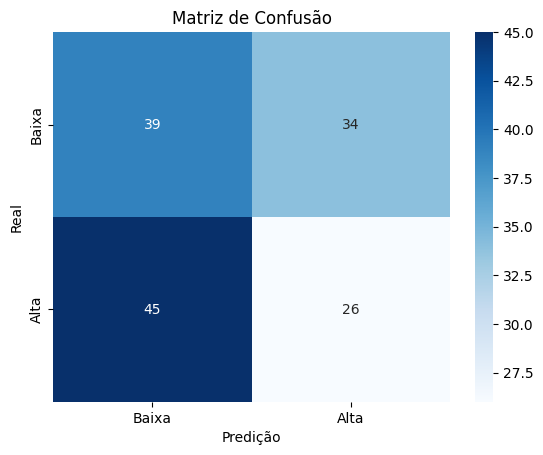

In [177]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Baixa", "Alta"], yticklabels=["Baixa", "Alta"])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()
